# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

*    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
*    Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
 Молодец, что собираешь импорты в одну ячейку и помещаешь ее в начале проекта!

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

В нашем распоряжении набор фотографий, а также таблица, в которой указан возраст человека на фотографии. 

Для начала посмотрим на таблицу.

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В таблице содержатся данные о 7591 фотографии. Пропусков данных нет. Средний возраст людей на них — 31 год, медианный возраст — 29 лет. Есть фотографии людей с возрастом 1 год и 100 лет. Стоит убедиться, что на этих фото возраст проставлен правильно.

Для начала построим гистограмму возрастов людей на фотографиях.

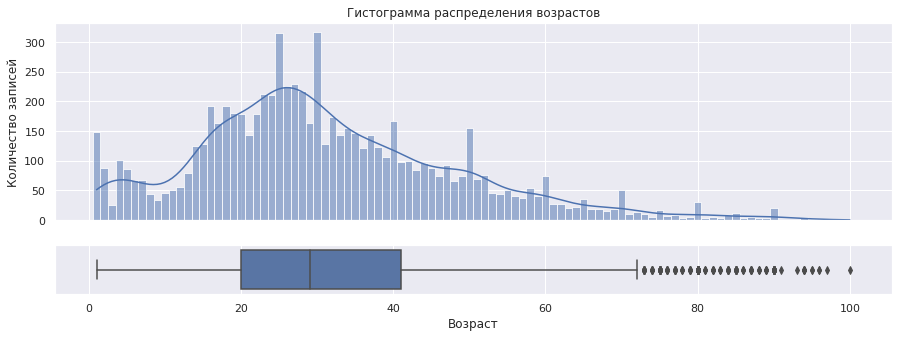

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='real_age', discrete=True,
             kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения возрастов',
     ylabel='Количество записей')
sns.boxplot(data=df, x='real_age', ax=axs_box)\
.set(xlabel='Возраст');

Гистограмма выглядит правдоподобно. Возраст людей на фото начинается от одного года, меньше всего фотографий людей примерно 10 лет и старше 60 лет. Нижний и верхний квантили приходятся на возраста от 20 до 41 года. Видны ярковыраженные пики в районе «круглых» возрастов, возможно при заполнении этой колонки данные о возрасте для некоторых фотографий округлялись.

Убедимся, что возраст людей на фотографиях размечен правильно. Посмотрим на фотографии людей старше 90 лет.

In [ ]:
seniors = df[df['real_age'] >= 90]

Age: 97


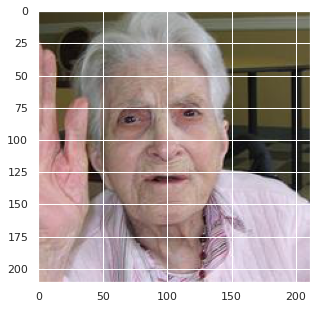

Age: 96


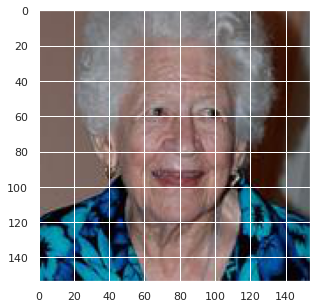

Age: 90


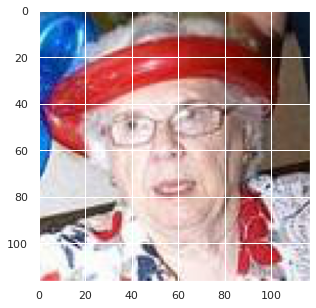

Age: 90


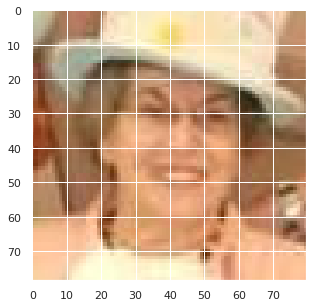

Age: 90


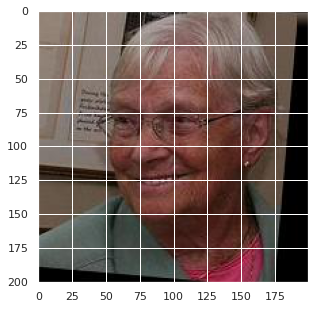

In [ ]:
for _, row in seniors.sample(5, random_state=42).iterrows():
    print('Age:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Похоже, что эти фотографии размечены правильно. Теперь посмотрим на фотографии людей возрастом до 5 лет.

In [ ]:
juniors = df[df['real_age'] < 5]

Age: 1


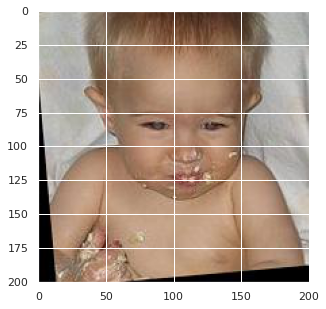

Age: 1


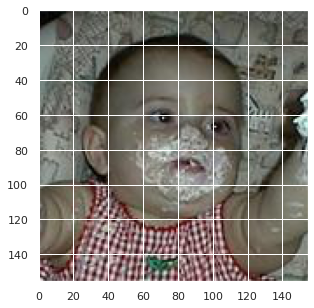

Age: 1


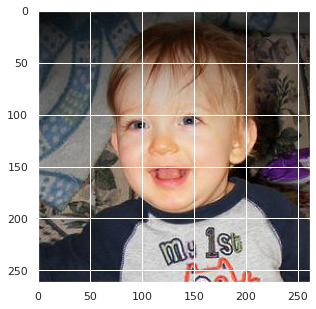

Age: 1


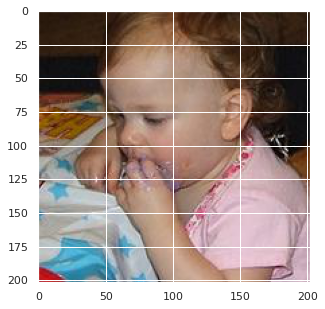

Age: 3


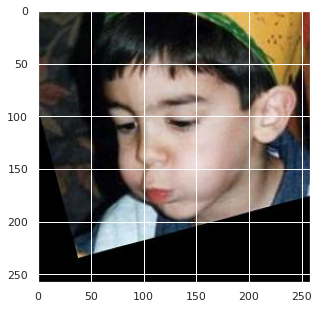

In [ ]:
for _, row in juniors.sample(5, random_state=42).iterrows():
    print('Age:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Чтож, и здесь проблем не видно. Дети как дети, на свой возраст они и выглядят.

**Вывод**

В нашем распоряжении набор фотографий, а также таблица, в которой указан возраст человека на фотографии. Мы провели небольшое исследование данных. В таблице содержатся записи о 7591 фотографии. Средний возраст людей на них — 31 год, медианный возраст — 29 лет. Есть фотографии людей с возрастом 1 год и 100 лет.

При выводе 10 случайных фотографий с людей с возрастами старше 90 лет и моложе 5 лет мы не обнаружили фотографий с некорректно размеченным возрастом. Видно, что фотографии имеют разное разрешение, но при обучении их надо будет привести к одному формату. Также видно, что фотографии сделаны под разными углами, видимо ранее с ними уже была произведена аугментация и при обучении модели этот шаг можно будет упростить.

В целом можно заключить, что данные готовы для обучения модели и дополнительная обработка не требуется.

## Обучение модели

Обучим модель на имеющихся данных. В качестве аугментаций будем использовать только горизонтальное переворачивание.

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       validation_split=0.25,
                                       rotation_range = 90)
                                       #vertical_flip=True,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs=20,
                batch_size=None, steps_per_epoch=None,
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps

Epoch 1/20
356/356 - 70s - loss: 271.3249 - mae: 12.3508 - val_loss: 630.7420 - val_mae: 20.1260

Epoch 2/20

356/356 - 61s - loss: 143.4376 - mae: 9.1243 - val_loss: 217.7602 - val_mae: 11.2578

Epoch 3/20

356/356 - 61s - loss: 124.3003 - mae: 8.4509 - val_loss: 115.7077 - val_mae: 8.1581

Epoch 4/20

356/356 - 61s - loss: 109.9173 - mae: 7.9979 - val_loss: 100.3030 - val_mae: 7.9389

Epoch 5/20

356/356 - 61s - loss: 100.4513 - mae: 7.6716 - val_loss: 124.3907 - val_mae: 8.2717

Epoch 6/20

356/356 - 61s - loss: 93.4184 - mae: 7.4209 - val_loss: 98.9533 - val_mae: 7.6570

Epoch 7/20

356/356 - 61s - loss: 83.5706 - mae: 6.9490 - val_loss: 119.9916 - val_mae: 8.3729

Epoch 8/20

356/356 - 61s - loss: 75.9502 - mae: 6.6844 - val_loss: 114.7630 - val_mae: 7.8806

Epoch 9/20

356/356 - 61s - loss: 73.7921 - mae: 6.6370 - val_loss: 95.5365 - val_mae: 7.4846

Epoch 10/20

356/356 - 61s - loss: 68.4487 - mae: 6.3376 - val_loss: 102.6637 - val_mae: 7.7050

Epoch 11/20

356/356 - 61s - loss: 60.8023 - mae: 5.9331 - val_loss: 91.2744 - val_mae: 7.2043

Epoch 12/20

356/356 - 65s - loss: 56.0470 - mae: 5.8113 - val_loss: 129.8072 - val_mae: 8.8751

Epoch 13/20

356/356 - 64s - loss: 54.4484 - mae: 5.6969 - val_loss: 120.8191 - val_mae: 8.5508

Epoch 14/20

356/356 - 64s - loss: 52.0669 - mae: 5.5252 - val_loss: 99.8947 - val_mae: 7.4277

Epoch 15/20

356/356 - 67s - loss: 50.8236 - mae: 5.4518 - val_loss: 140.3298 - val_mae: 9.1374

Epoch 16/20

356/356 - 76s - loss: 46.7002 - mae: 5.2785 - val_loss: 97.8693 - val_mae: 7.5721

Epoch 17/20

356/356 - 76s - loss: 42.6543 - mae: 5.0216 - val_loss: 87.6095 - val_mae: 7.1290

Epoch 18/20

356/356 - 65s - loss: 40.7311 - mae: 4.9239 - val_loss: 132.8505 - val_mae: 8.7686

Epoch 19/20

356/356 - 64s - loss: 41.4613 - mae: 4.9104 - val_loss: 100.1209 - val_mae: 7.2914

Epoch 20/20

356/356 - 61s - loss: 40.2176 - mae: 4.8243 - val_loss: 91.5488 - val_mae: 7.1712

119/119 - 9s - loss: 91.5488 - mae: 7.1712

Test MAE: 7.1712


```

## Анализ обученной модели

Мы построили модель, которая по фотографии человека определяет его возраст со средней ошибкой в 7,2 года.

Заказчик планирует использовать её чтобы:

*    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
*    Контролировать добросовестность кассиров при продаже алкоголя.

Можно утверждать, что качество модели может быть достаточно для того, чтобы решать первую задачу. Если предположить, что возрастные группы будут определяться примерно так: подростки (до 18 лет), молодёжь (от 18 до 35 лет), средний возраст (от 35 до 50 лет), старшее поколение (от 50 лет и старше), то в большинстве случаев мы будем правильно предсказывать возрастную группу.

С другой стороны, качество модели недостаточно для того, чтобы автоматизировать контроль добросовестности кассиров при продаже алкоголя. Модель можно использовать лишь для предотбора случаев продажи алкоголя с последующим контролем со стороны человека. Например, можно фиксировать все случаи продажи алкоголя покупателям с предсказанным возрастом до 30 лет и отправлять их для контроля ответственному лицу.

Стоит также отметить, что у нас относительно мало фотографий людей старшего возраста (старше 50 лет). Возможно при добавлении в выборку фотографий людей этого возраста метрика модели может улучшиться.